### Vajalikud moodulid.

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from estnltk import Text
from scipy import sparse as sp_sparse
#from estnltk.taggers import SentenceTokenizer
from sklearn import metrics
from matplotlib.cm import bwr
from sklearn.feature_extraction.text import CountVectorizer
from scipy import spatial as spatial 
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans
import Levenshtein as lev
import sys
sys.path.append("..")
import os
np.random.seed(0)


In [69]:
cmap = sn.cubehelix_palette(15, start=5, rot=1, dark=0.2, light=.65)
cmap_r = sn.cubehelix_palette(15, start=3, rot=1, dark=0.2, light=.95, reverse=True)

# Treeningandmete ettevalmistamine
Sobivat klassifitseeritud seaduse lausetest koosnevat andmebaasi minu andmaetel ei ole. Seega on vaja leida sobivad klassid otse seaduste originaaltekstidest. 
## Treeningandmete eeltöötlus 

### Seadusetekstide laadimine
Treeningandmete loomisel kasutame kaustas data olevaid seaduste originaal tekste.
Laadime failide tekstid DataFrame'i data_in veergu texts.
Leiame teksti lõikude tüübid ja eemaldame tekstist numeratsiooni.

In [3]:
data_in =pd.DataFrame()
files=os.listdir('data')
for file in files:
    with open('data/'+ file,encoding="utf-8") as f:
        data =pd.DataFrame( f.readlines(),columns=["texts"])
    data_in = data_in.append(data, ignore_index=True)
    
data_in['texts'] = data_in['texts'].str.replace("\n","")
data_in.drop(data_in[data_in['texts'].str.len()==0].index, inplace = True)
data_in['texts'] =data_in['texts'].str.split(" ",1)
data_in['nmbr'] = data_in['texts'].str[0]
data_in['texts'] =data_in['texts'].str[1]
data_in['types']=np.where(data_in['nmbr'].str.endswith(')'),'lg','nan')
#data_in['types']=np.where(data_in['nmbr'].str.startswith('('),'lg',data_in['types'])
data_in['types'] = np.where(data_in['nmbr'].str.startswith('§'),'par',data_in['types'])
data_in['types'] = np.where(data_in['texts'].str.startswith('peatükk'),'ptk',data_in['types'])
data_in['types'] = np.where(data_in['nmbr'].str.startswith('['),'m',data_in['types'])
data_in['types'] = np.where(data_in['texts'].str.startswith('['), "keht", data_in['types'])
data_in['texts'] = data_in['texts'].str.replace('nan', " ")
data_in[130:135]

,texts,nmbr,types
189,hankeleping on seotud riigisaladusega või väli...,20),lg
190,ta sõlmib keskse hankijaga kokkuleppe riigihan...,21),lg
192,Hankelepingu sõlmimisel või ideekonkursi korra...,(2),lg
194,Käesoleva paragrahvi lõike 1 punktis 2 nimetat...,(3),lg
196,12. Sisetehing ja hankijatevaheline koostöö,§,par


Seaduse lõigete sisu on struktureeritud - loendid on välja toodud eraldi punktides. Selleks et säilitada see struktuuri osa lisame täiendavad punkti märgid, muutes seega loendi kõik osad eraldi lauseteks. 
Võtame andmetest välja kõit peatükkide ja paragrahvide pealkirjad. Seega jääb andmetesse ainult seaduse lõigete sisu.

In [4]:
data_in.drop(data_in[data_in['types'] != 'lg'].index, inplace = True)
data_in['texts']=np.where(data_in['texts'].str.endswith('.'),data_in['texts'],[text+'.'for text in data_in['texts']])
data_in[130:135]

,texts,nmbr,types
239,"asjade või teenuste hankelepingu, Euroopa Parl...",1),lg
240,ehitustööde hankelepingu korral 150 000 eurot;.,2),lg
241,Euroopa Parlamendi ja nõukogu direktiivi 2014/...,3),lg
243,"Rahvusvaheline piirmäär, sealhulgas sotsiaal- ...",(3),lg
245,Kaitse- ja julgeolekuvaldkonna rahvusvaheline ...,(4),lg


###  Laused
Esialgselt keskendume lausete lihtsustamisele. Seega jagame lõigete tekstid eraldi lauseteks ja loome uue DataFrame.

In [5]:
lg_text=Text(''.join(list(data_in['texts']))).tag_layer()
data_sent = pd.DataFrame( [' '.join(s) for s in lg_text.sentences.text ],columns=["texts"])
data_sent.shape

(10172, 1)

Arvitame lausete pikkused.

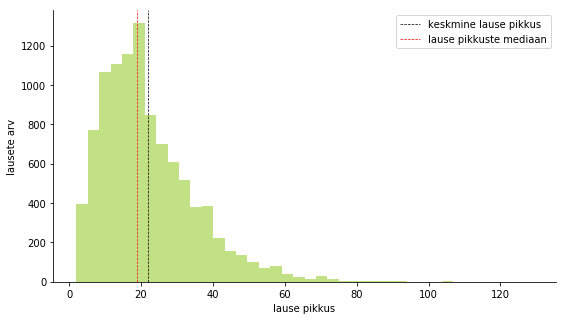

In [6]:
#sns.plt.show()
data_sent['length'] = [len(text.split(' '))  for text in data_sent['texts']]
fig = plt.figure(figsize=(9, 5))
plt.clf()
ax=plt.gca()
_ =plt.hist(data_sent['length'], 40, facecolor='yellowgreen', alpha=0.6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.axvline(data_sent['length'].mean(), color='k', linestyle='dashed', linewidth=.7,label='keskmine lause pikkus')
plt.axvline(data_sent['length'].median(), color='r', linestyle='dashed', linewidth=.7, label='lause pikkuste mediaan')
plt.xlabel('lause pikkus')
plt.ylabel('lausete arv')
plt.legend()
plt.show()

In [7]:
data_sent.shape

(10172, 2)

Leiame enim kasutatud sõnad ja tegusõnad.

In [8]:
lemma_stamp = Counter([l[0].lemma for l in lg_text.morph_analysis if ( l[0].partofspeech != 'V' and l[0].partofspeech != 'Z')])
lemma_verbs = Counter([l[0].lemma for l in lg_text.morph_analysis if l[0].partofspeech == 'V'])
lemmas=list(zip(*(lemma_stamp.most_common(10)+lemma_verbs.most_common(5))))[0]
#lemmas=list(zip(*(lemma_verbs.most_common(5))))[0]
spets_words = list(lemmas) +  ['järgmine']
#spets_words = ['järgmine']
str(spets_words)

"['või', 'ja', 'kui', 'käesolev', 'see', 'lõige', 'mis', 'seadus', 'tema', 'isik', 'olema', 'ei', 'võima', 'pidama', 'esitama', 'järgmine']"

Teisendame laused lemmade ja pos_tag'ide jadaks


In [9]:
def pos_or_lemma(lists):
    return [pl[1] if (pl[1] in spets_words or pl[0]=='Z' ) else ''.join(list(set(pl[0]))) for pl in lists]
def pos_and_ends(lists):
    return [pl[0] if (pl[1]=='0' ) else '_'.join(pl) for pl in lists]
def pos_list(lists):
    return ' '.join([''.join(list(set(pl))) for pl in lists])
def lem_list(lists):
    return ' '.join([pl[0] for pl in lists])
def pos_lemma(row):
    pos_lemma =  [list(zip(row[0].split(' '), row[1].split(' ')))]
    pos_or_lemmas = [pos_or_lemma(p_or_l)  for p_or_l in pos_lemma]
    return [' '.join(pos) for pos in pos_or_lemmas]
def pos_end(lists):
    pos_ends =  [list(zip(lists[0].split(' '), lists[1].split(' ')))]
    pos_ends = [pos_and_ends(p)  for p in pos_ends]
    return [' '.join(pos) for pos in pos_ends]    


In [10]:
data_sent['pos'] = [pos_list(Text(text).tag_layer().morph_analysis.partofspeech) for text in data_sent['texts']]
data_sent['lemma'] = [lem_list(Text(text).tag_layer().morph_analysis.lemma)  for text in data_sent['texts']]
data_sent['ends'] =[lem_list(Text(text).tag_layer().morph_analysis.ending)  for text in data_sent['texts']]
#data_sent['vorms'] =[lem_list(Text(text).tag_layer().morph_analysis.form)  for text in data_sent['texts']]

In [11]:
data_sent['pos_ends_str'] = [' '.join(pos_end(row)) for row in zip(data_sent['pos'],data_sent['ends'])]
data_sent['pos_or_lemma_str'] = [' '.join(pos_lemma(row)) for row in zip(data_sent['pos'],data_sent['lemma'])]

In [12]:
data_sent['pos_ends_lemma_str'] = [' '.join(pos_end(row)) for row in zip(data_sent['pos_ends_str'],data_sent['lemma'])]

In [13]:
data_sent.head()

,texts,length,pos,lemma,ends,pos_ends_str,pos_or_lemma_str,pos_ends_lemma_str
0,Käesolev seadus sätestab riigihanke korraldami...,30,A S V S S S Z S AV S S J S Z A S J S S Z S S S...,käesolev seadus sätestama riigihange korraldam...,0 0 b 0 0 d ga 0 te d 0 d 0 0 0 0 0 te 0 0 ...,A S V_b S S S_d Z_ S_ga AV S_te S_d J S_d Z_ A...,"käesolev seadus V S S S , S AV isik S ja S , A...",A_käesolev S_seadus V_b_sätestama S_riigihange...
1,Juurdepääs riigihangete andmetele ning nende a...,24,S S S J P S S J S V A S S AV S Z JD A S V V AV...,juurdepääs riigihange andmed ning see andmed v...,0 te tele 0 de te 0 0 0 b 0 0 s 0 s 0 s s 0 0...,S S_te S_tele J P_de S_te S J S V_b A S S_s AV...,"S S S J see S S ja S V A S seadus AV S , kui k...",S_juurdepääs S_te_riigihange S_tele_andmed J_n...
2,Käesoleva seaduse eesmärk on tagada hankija ra...,24,A S S V V S A S A Z A J A S Z S A S J S A S S Z,käesolev seadus eesmärk olema tagama hankija r...,0 0 0 0 da 0 te te 0 0 0 0 0 te 0 0 0 0 0 0 l,A S S V V_da S A_te S_te A Z_ A J A S Z_ S_te ...,"käesolev seadus S olema V S A S A , A ja A S ,...",A_käesolev S_seadus S_eesmärk V_olema V_da_tag...
3,Riigihangete planeerimisel ja korraldamisel ar...,14,S S J S V A S Z S S J A S Z,riigihange planeerimine ja korraldamine arvest...,te l 0 l takse te te 0 0 0 e tega,S_te S_l J S_l V_takse A_te S_te Z_ S S J A_e ...,"S S ja S V A S , S S J A S .",S_te_riigihange S_l_planeerimine J_ja S_l_korr...
4,Riigihanke korraldamisel on hankija kohustatud...,10,S S V S AV V A S Z Z,riigihange korraldamine olema hankija kohustat...,0 l 0 0 0 ma i id,S S_l V S AV V_ma A_i S_id Z_ Z_,S S olema S AV V järgmine S : .,S_riigihange S_l_korraldamine V_olema S_hankij...


In [14]:
def lev_dist_matr (texts):
    return np.array([lev.distance(text1, text2) for text1 in texts  for text2 in texts]).reshape(len(texts),len(texts))


In [59]:
sort_sent = data_sent.sort_values(['length'])
sort_sent.head()

,texts,length,pos,lemma,ends,pos_ends_str,pos_or_lemma_str,pos_ends_lemma_str,semi_k,verbs,comma,erand,len_gr
3782,Terviseamet .,2,S Z,terviseamet .,0,S Z_,S .,S_terviseamet Z__.,0,0,0,0,0
2352,ärisaladust .,2,S Z,ärisaladus .,t,S_t Z_,S .,S_t_ärisaladus Z__.,0,0,0,0,0
2672,tehnoloogiale .,2,S Z,tehnoloogia .,le,S_le Z_,S .,S_le_tehnoloogia Z__.,0,0,0,0,0
2572,köistee .,2,S Z,köistee .,0,S Z_,S .,S_köistee Z__.,0,0,0,0,0
376,kontsessiooniteade .,2,S Z,kontsessiooniteade .,0,S Z_,S .,S_kontsessiooniteade Z__.,0,0,0,0,0


[]

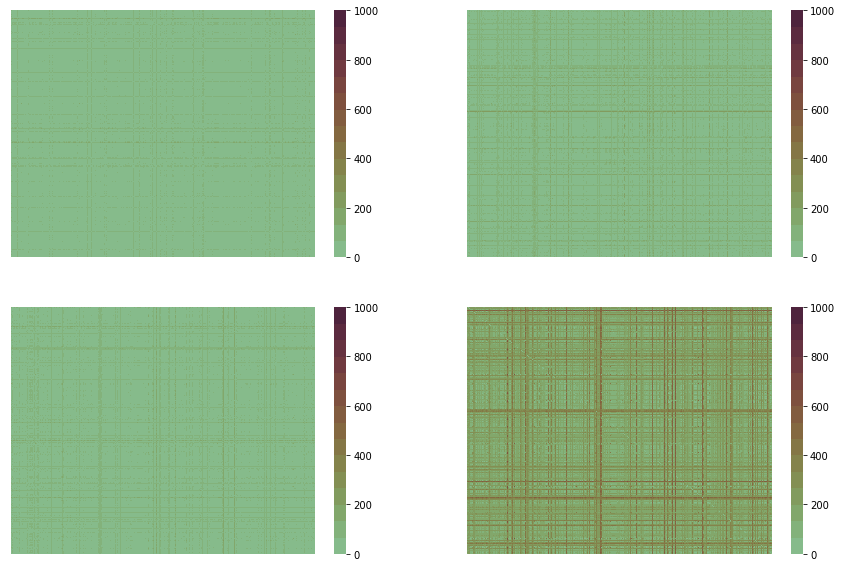

In [68]:
f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
sn.heatmap( lev_dist_matr(data_sent['pos'].sample(frac=0.1)) , ax=axes[0, 0],cmap=cmap,vmin=0, vmax=1000)
sn.heatmap( lev_dist_matr(data_sent['pos_ends_str'].sample(frac=0.1)) , ax=axes[0, 1],cmap=cmap,vmin=0, vmax=1000)
sn.heatmap( lev_dist_matr(data_sent['pos_or_lemma_str'].sample(frac=0.1)), ax=axes[1, 0],cmap=cmap,vmin=0, vmax=1000)
sn.heatmap( lev_dist_matr(data_sent['pos_ends_lemma_str'].sample(frac=0.1)) , ax=axes[1, 1],cmap=cmap,vmin=0, vmax=1000)
plt.setp(axes, yticks=[], xticks=[])

Käsitsi lisatud reeglid.

In [38]:
def del_words(lemmas):
    del_word = ['käesolev','järgmine', 'pool', 'kohta' ,'eeldama']
    return [1 if le in del_word else 0 for le in lemmas.split(' ')]
data_sent['semi_k'] = [sum(del_words(le)) for le in data_sent['lemma']]

In [39]:
data_sent['verbs'] = [len(re.findall(r'V |V.', p)) for p in data_sent['pos']]
data_sent['comma'] = [len(re.findall(r'Z.*V.*Z', p)) for p in data_sent['pos']]
data_sent['erand'] = [len(re.findall(r',.välja arvatud.*,', p)) for p in data_sent['lemma']]

In [40]:
labels = [ 0, 15, 25, 40, 60 ]
data_sent['len_gr'] = pd.cut(data_sent['length'], [0, 15, 25, 40, 60, 130], right=False, labels=labels)
#data_sent['long'] = np.where(data_sent['length']>8,100,1)
#data_sent['longest'] = np.where(data_sent['length']>55,100,1)


Lausete pikkust kirjeldavad näitajad.

In [41]:
data_sent_short = data_sent[data_sent['length']<9].copy()
data_sent_mean = data_sent[data_sent['length']>8].copy()
data_sent_mean.drop(data_sent_mean[data_sent_mean['length']>40].index, inplace = True)
data_sent_long = data_sent[data_sent['length']>40].copy()

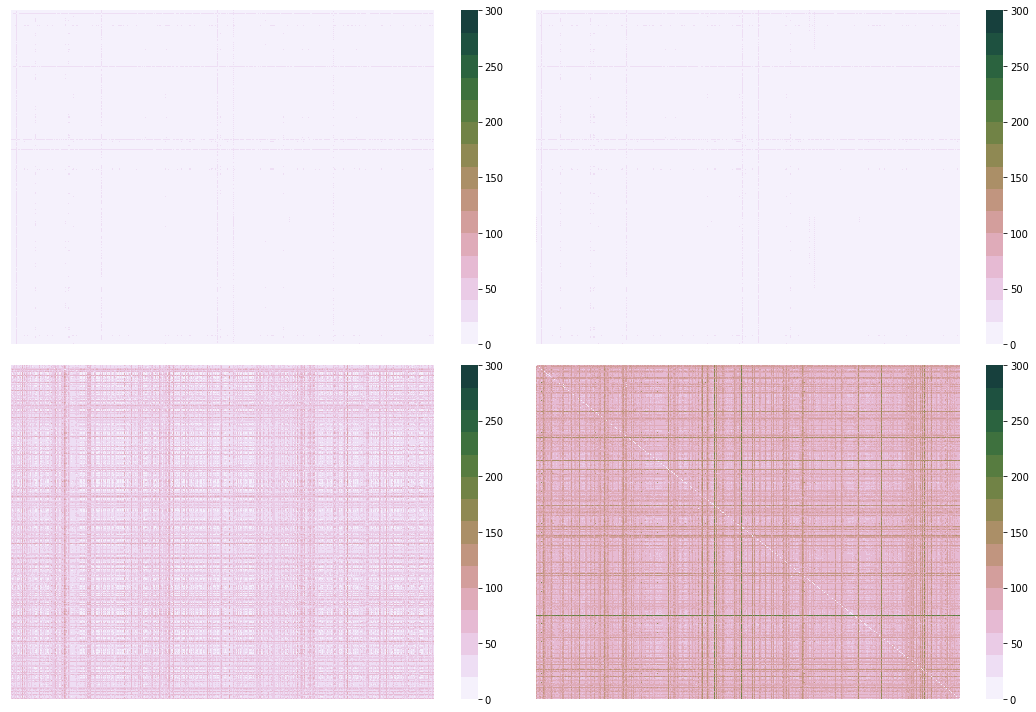

In [42]:
plt.clf()
f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
sn.heatmap( lev_dist_matr(data_sent['pos_or_lemma_str']), ax=axes[0, 0],cmap=cmap,vmin=0, vmax=300)
sn.heatmap( lev_dist_matr(data_sent_short['pos_or_lemma_str']), ax=axes[0, 1],cmap=cmap,vmin=0, vmax=300)
sn.heatmap( lev_dist_matr(data_sent_mean['pos_or_lemma_str']), ax=axes[1, 0],cmap=cmap,vmin=0, vmax=300)
sn.heatmap( lev_dist_matr(data_sent_long['pos_or_lemma_str']), ax=axes[1, 1],cmap=cmap,vmin=0, vmax=300)

plt.setp(axes, yticks=[], xticks=[])
plt.tight_layout()

In [43]:
names=['len_gr','semi_k', 'verbs', 'comma','erand']
(data_sent).columns

Index(['texts', 'length', 'pos', 'lemma', 'ends', 'pos_ends_str',
       'pos_or_lemma_str', 'pos_ends_lemma_str', 'semi_k', 'verbs', 'comma',
       'erand', 'len_gr'],
      dtype='object')

In [44]:
my_feat=data_sent_mean[names].copy()
my_feat.head()

,len_gr,semi_k,verbs,comma,erand
0,25,2,2,1,0
1,15,1,5,1,0
2,15,1,2,0,0
3,0,0,1,0,0
4,0,1,3,0,0


In [45]:
from sklearn.decomposition import TruncatedSVD

def vectorizer_sum(text,my_feat,n):
    tf_vect = TfidfVectorizer(encoding='utf-8', token_pattern='(\S+)', ngram_range=(4, 12),max_df=.95, min_df=10)
    text_tf = tf_vect.fit_transform(text)

    svd=TruncatedSVD(algorithm='randomized', n_components=n, n_iter=1000, random_state=0, tol=0.0)
    text_tf_svd = svd.fit_transform(text_tf)

    text_tf =np.concatenate((my_feat,text_tf_svd), axis=1)
    normalizer = Normalizer(copy=False)
    text_tf =  normalizer.fit_transform(text_tf)
    return text_tf

In [46]:
def clustering_in(text, feat,i , j):
    kmeans = KMeans(n_clusters = i, random_state = 0)

    text_tf=vectorizer_sum(text, feat, j)
    cls = kmeans.fit_predict(text_tf)
    return metrics.silhouette_score(text_tf, cls, sample_size=None)
   
def clustering_matr(text, feat):
    ii = [700, 600,500, 400, 300, 200 ,150 ,100 ,75 ,50 , 25, 20]
    jj = [300,200,100,80, 60, 55, 50, 25, 20]
    sil_sc =np.zeros((len(ii),len(jj)))
    for i in range (0,len(ii)):
        sil_sc[i] =[clustering_in(text, feat,ii[i] , jj[j]) for j in range(0, len(jj))]
    return sil_sc


In [47]:
sil_matr1 = clustering_matr(data_sent_mean['pos_or_lemma_str'], my_feat)

In [48]:
np.unravel_index(np.argmax(sil_matr1, axis=None), sil_matr1.shape)                    

(3, 8)

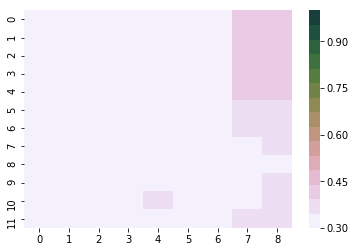

In [49]:
ax = sn.heatmap(sil_matr1,vmin=0.3, vmax=1,cmap=cmap)    

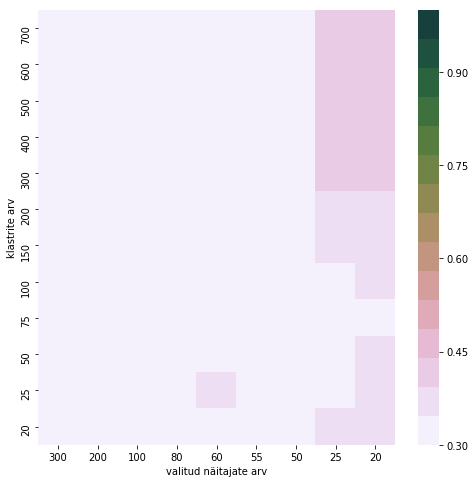

In [50]:
plt.figure(figsize=(8,8))
ax = sn.heatmap(sil_matr1,vmin=0.3, vmax=1,cmap=cmap)    
ax.set_ylabel('klastrite arv')
ax.set_xlabel('valitud näitajate arv')
ax.set_xticklabels([300,200,100,80, 60, 55, 50, 25, 20], fontsize=10)
ax.set_yticklabels([700, 600,500, 400, 300, 200 ,150 ,100 ,75 ,50 , 25, 20], rotation='vertical', fontsize=10)
plt.show()


In [ ]:
sns.distplot( df["sepal_length"], bins=20 )
#sns.plt.show()


In [ ]:
sil_matr2 = clustering_matr(data_sent[0:2000]['pos_or_lemma_str'], my_feat[0:2000])

In [ ]:

plt.figure(figsize=(8,8))
ax = sn.heatmap(sil_matr2,vmin=0.3, vmax=1,cmap=cmap)    
ax.set_ylabel('klastrite arv')
ax.set_xlabel('valitud näitajate arv')
ax.set_xticklabels([300,200,100,80, 60, 55, 50, 25, 20], fontsize=10)
ax.set_yticklabels([700, 600,500, 400, 300, 200 ,150 ,100 ,75 ,50 , 25, 20], rotation='vertical', fontsize=10)
plt.show()

In [ ]:
sil_matr3 = clustering_matr(data_sent[0:2000]['pos_ends_str'], my_feat[0:2000])

In [ ]:
plt.figure(figsize=(8,8))
ax = sn.heatmap(sil_matr3,vmin=0.3, vmax=1,cmap=cmap)    
ax.set_ylabel('klastrite arv')
ax.set_xlabel('valitud näitajate arv')
ax.set_xticklabels([300,200,100,80, 60, 55, 50, 25, 20], fontsize=10)
ax.set_yticklabels([700, 600,500, 400, 300, 200 ,150 ,100 ,75 ,50 , 25, 20], rotation='vertical', fontsize=10)
plt.show()


In [ ]:
import Levenshtein as lev

In [ ]:
max_m1 = np.unravel_index(np.argmax(sil_matr1, axis=None), sil_matr1.shape)   

In [ ]:
data_k=data_sent.copy()

In [ ]:
agg = AgglomerativeClustering(n_clusters=20, affinity='cosine', memory=None, connectivity=None, 
                        compute_full_tree='Auto', linkage='average')
text_tf=vectorizer_sum(data_sent['pos_ends_lemma_str'], my_feat, 50)
data_k['cls1'] = agg.fit_predict(text_tf)

In [ ]:
max_m2 = np.unravel_index(np.argmax(sil_matr2, axis=None), sil_matr2.shape)  
max_m2

In [52]:
agg = AgglomerativeClustering(n_clusters=25, affinity='cosine', memory=None, connectivity=None, 
                        compute_full_tree='Auto', linkage='average')
text_tf=vectorizer_sum(data_sent_mean['pos_or_lemma_str'], my_feat, 50)
data_k['cls2'] = agg.fit_predict(text_tf)

NameError: name 'data_k' is not defined

In [ ]:
max_m3 = np.unravel_index(np.argmax(sil_matr3, axis=None), sil_matr3.shape)  
max_m3

In [ ]:
agg = AgglomerativeClustering(n_clusters=20, affinity='cosine', memory=None, connectivity=None, 
                        compute_full_tree='Auto', linkage='average')
text_tf=vectorizer_sum(data_sent['pos_ends_str'], my_feat, 50)
data_k['cls3'] = agg.fit_predict(text_tf)

In [ ]:
data_k.to_csv("sent_k.csv", sep=';', header=True)

In [ ]:
lev_dist_matr =np.array([lev.distance(text1, text2) for text1 in data_sent['pos_ends_str'] 
    for text2 in data_sent['pos_ends_str']]).reshape(len(data_sent),len(data_sent['pos_ends_str']))
fig = plt.figure(figsize=(15, 10))
dist_heat = sn.heatmap(lev_dist_matr)

In [ ]:
from sklearn.cluster import KMeans
data_k_means=data_sent.copy()
har_sc = []
sil_sc =[]

In [ ]:
for i in [1500, 1000,900,800,700,600,500,400,350,300,200,150,125,100,75,50,25]:
    kmeans = KMeans(n_clusters = i, random_state = 0)

    clsk = kmeans.fit_predict(text_co)

    b = 'k_mean_co'+str(i)
    data_k_means[b]=clsk
    p = metrics.calinski_harabaz_score(text_co, clsk)
    har_sc = har_sc + [p]
    print("Calinski Harabaz Score: %0.3f" %p )

    s = metrics.silhouette_score(text_co, clsk, metric='cosine', sample_size=None)
    sil_sc =sil_sc +[s]
    print("Silhouette Coefficient: %0.3f" % s)
    print()
    

In [ ]:
_ = data_k_means.to_csv("k_meansco.csv", sep=';', header=True)
data_k_means.head()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(text_co, 'ward')

plt.figure()
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=55,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)

plt.show()

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram
plt.figure()
dendrogram(ward(text_co))
plt.show()